In [68]:
from datasets import load_from_disk

In [69]:
ds = load_from_disk("/home/pl487/anchoral/data/prepared/agnews_original_bert-tiny")

In [70]:
ds

DatasetDict({
    train: Dataset({
        features: ['uid', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['uid', 'labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

In [59]:
from pprint import pprint

import torch
from torchmetrics import MeanMetric, MetricCollection
from torchmetrics.classification import (
    AUROC,
    Accuracy,
    AveragePrecision,
    F1Score,
    MulticlassAccuracy,
    MulticlassF1Score,
    Precision,
    Recall,
    Specificity,
)
from torchmetrics.wrappers import BootStrapper, ClasswiseWrapper

_ = torch.manual_seed(42)
preds = torch.randn(10, 3).softmax(dim=-1)
target = torch.randint(3, (10,))
loss = torch.tensor([0.0])

# # classwise = ClasswiseWrapper(base_metric, prefix="acc-")

# bootstrap_acc = BootStrapper(MulticlassAccuracy(num_classes=3, average=None), num_bootstraps=20)
# bootstrap_f1 = BootStrapper(MulticlassF1Score(num_classes=3, average=None), num_bootstraps=20)


# # metrics_list = MetricCollection([bootstrap_acc, bootstrap_f1])  # same as MetricCollection(bootstrap_acc, bootstrap_f1)
# metrics_dict = MetricCollection({"acc": bootstrap_acc, "f1": bootstrap_f1})
# # metrics = MetricCollection([MetricCollection(bootstrap_acc), MetricCollection(bootstrap_f1)])


# bootstrap_f1(preds, target)

In [63]:
def get_metrics(task: str, num_classes: int, average: str):
    suffix = "perclass" if average == "none" else average
    return {
        f"accuracy_{suffix}": Accuracy(task, num_classes=num_classes, average=average),
        f"f1_{suffix}": F1Score(task, num_classes=num_classes, average=average),
        f"precision_{suffix}": Precision(task, num_classes=num_classes, average=average),
        f"recall_{suffix}": Recall(task, num_classes=num_classes, average=average),
        f"specificity_{suffix}": Specificity(task, num_classes=num_classes, average=average),
    }


stage = "train"
task = "multiclass"
num_classes = 3
metrics = MetricCollection(
    {
        **get_metrics(task, num_classes, "none"),
        **get_metrics(task, num_classes, "micro"),
        "auprc_perclass": AveragePrecision(
            task, num_classes=num_classes, average="none", thresholds=None
        ),
        "auroc_perclass": AUROC(task, num_classes=num_classes, average="none", thresholds=None),
        "bootstrapped_f1_p": BootStrapper(
            F1Score(task, num_classes=num_classes, average="none"), num_bootstraps=200
        ),
        "bootstrapped_f1": BootStrapper(
            F1Score(task, num_classes=num_classes, average="none"), num_bootstraps=200
        ),
        # "loss": MeanMetric(),
        # don't need macro as it is a simple average of the per-class scores
        # **get_metrics(num_classes, "macro"),
    },
    prefix=f"{stage}/",
)

In [66]:
b = MetricCollection(
    {
        "a": BootStrapper(
            F1Score(task, num_classes=num_classes, average="none"), num_bootstraps=200
        ),
        "b": F1Score(task, num_classes=num_classes, average="none"),
        # "c": BootStrapper(F1Score(task, num_classes=num_classes, average="none"), num_bootstraps=200),
        **get_metrics(task, num_classes, "micro"),
        **get_metrics(task, num_classes, "none"),
        "auroc_perclass": AUROC(task, num_classes=num_classes, average="none", thresholds=None),
        "auprc_perclass": AveragePrecision(
            task, num_classes=num_classes, average="none", thresholds=None
        ),
    }
)

In [65]:
metrics(preds, target)

{'train/accuracy_micro': tensor(0.5000),
 'train/accuracy_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'train/auprc_perclass': tensor([0.6083, 0.8500, 0.2000]),
 'train/auroc_perclass': tensor([0.7500, 0.7500, 0.2500]),
 'train/mean': tensor([0.4961, 0.7458, 0.0000]),
 'train/std': tensor([0.1072, 0.0823, 0.0000]),
 'train/f1_micro': tensor(0.5000),
 'train/f1_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'train/precision_micro': tensor(0.5000),
 'train/precision_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'train/recall_micro': tensor(0.5000),
 'train/recall_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'train/specificity_micro': tensor(0.7500),
 'train/specificity_perclass': tensor([0.6667, 0.8333, 0.7500])}

In [67]:
b(preds, target)

{'mean': tensor([0.4939, 0.7287, 0.0000]),
 'std': tensor([0.1622, 0.1454, 0.0000]),
 'accuracy_micro': tensor(0.5000),
 'accuracy_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'auprc_perclass': tensor([0.6083, 0.8500, 0.2000]),
 'auroc_perclass': tensor([0.7500, 0.7500, 0.2500]),
 'b': tensor([0.5000, 0.7500, 0.0000]),
 'f1_micro': tensor(0.5000),
 'f1_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'precision_micro': tensor(0.5000),
 'precision_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'recall_micro': tensor(0.5000),
 'recall_perclass': tensor([0.5000, 0.7500, 0.0000]),
 'specificity_micro': tensor(0.7500),
 'specificity_perclass': tensor([0.6667, 0.8333, 0.7500])}

In [22]:
metrics(preds=preds, target=target)

TypeError: torch.Size() takes an iterable of 'int' (item 0 is 'str')

In [93]:
classwise = ClasswiseWrapper(MulticlassAccuracy(num_classes=3, average=None), prefix="class")
classwise(preds, target)

{'class0': tensor(0.5000), 'class1': tensor(0.7500), 'class2': tensor(0.)}

In [132]:
f1_score = MulticlassF1Score(num_classes=3, average=None)

a = preds[:3]
b = torch.LongTensor([0, 0, 0])

f1_score(a, b), bootstrap_f1(a, b)

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [121]:
bootstrap_f1(preds, target)

{'mean': tensor([0.4976, 0.7697, 0.0000]),
 'std': tensor([0.0989, 0.0920, 0.0000])}

In [118]:
num_classes = 3
task = "multiclass"
metrics = MetricCollection(
    {
        # class-wise
        "accuracy_class": Accuracy(task, num_classes=num_classes, average="none"),
        "f1_class": F1Score(task, num_classes=num_classes, average="none"),
        "precision_class": Precision(task, num_classes=num_classes, average="none"),
        "recall_class": Recall(task, num_classes=num_classes, average="none"),
        # micro
        "accuracy_micro": Accuracy(task, num_classes=num_classes, average="micro"),
        "f1_micro": F1Score(task, num_classes=num_classes, average="micro"),
        "precision_micro": Precision(task, num_classes=num_classes, average="micro"),
        "recall_micro": Recall(task, num_classes=num_classes, average="micro"),
        # macro
        "accuracy_macro": Accuracy(task, num_classes=num_classes, average="macro"),
        "f1_macro": F1Score(task, num_classes=num_classes, average="macro"),
        "precision_macro": Precision(task, num_classes=num_classes, average="macro"),
        "recall_macro": Recall(task, num_classes=num_classes, average="macro"),
        # loss
        "loss": MeanMetric(),
    }
)

In [120]:
# boot = BootStrapper(F1Score(task, num_classes=num_classes, average="none"), num_bootstraps=20)

metrics(preds=preds, target=target, value=torch.tensor(0.0))  # , boot(preds, target)

{'accuracy_class': tensor([0.5000, 0.7500, 0.0000]),
 'accuracy_macro': tensor(0.4167),
 'accuracy_micro': tensor(0.5000),
 'f1_class': tensor([0.5000, 0.7500, 0.0000]),
 'f1_macro': tensor(0.4167),
 'f1_micro': tensor(0.5000),
 'loss': tensor(0.),
 'precision_class': tensor([0.5000, 0.7500, 0.0000]),
 'precision_macro': tensor(0.4167),
 'precision_micro': tensor(0.5000),
 'recall_class': tensor([0.5000, 0.7500, 0.0000]),
 'recall_macro': tensor(0.4167),
 'recall_micro': tensor(0.5000)}

In [88]:
bootstrap_f1.compute()

{'mean': tensor([0.4591, 0.7782, 0.0000]),
 'std': tensor([0.1795, 0.1072, 0.0000])}

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Step', ylabel='BootStrapper'>)

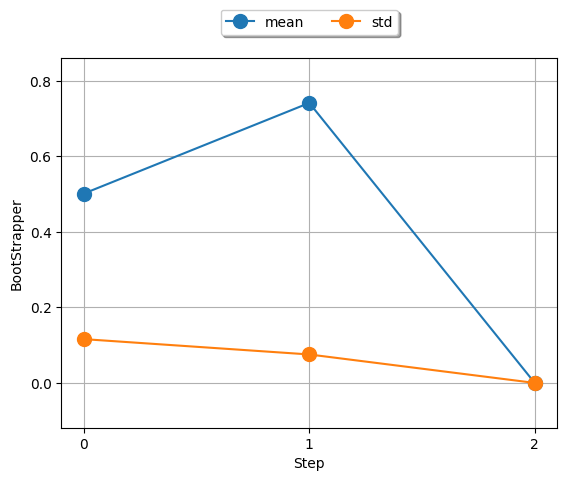

In [67]:
coll["d"].

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Step', ylabel='BootStrapper'>)

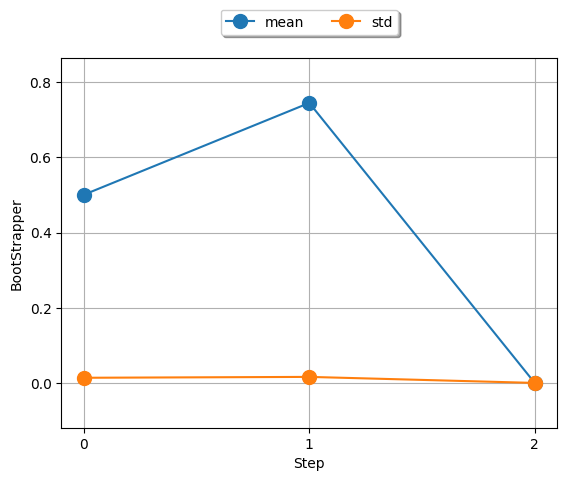

In [42]:
bootstrap.plot()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='ClasswiseWrapper'>)

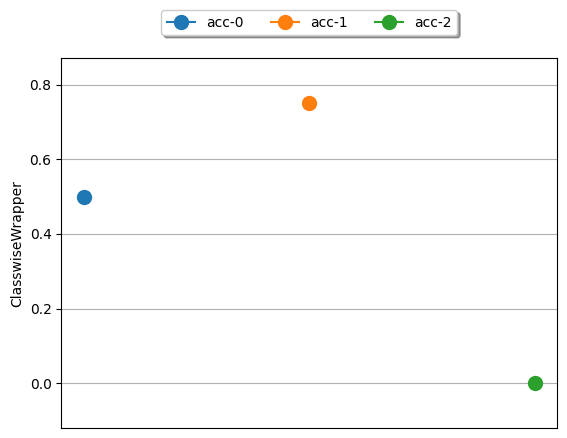

In [51]:
classwise.plot()

In [ ]:
from torchmetrics.wrappers import 
from torchmetrics.classification import MulticlassAccuracy
_ = torch.manual_seed(123)
base_metric = MulticlassAccuracy(num_classes=5, average='micro')
bootstrap = BootStrapper(base_metric, num_bootstraps=20)
bootstrap.update(torch.randint(5, (20,)), torch.randint(5, (20,)))
output = bootstrap.compute()
pprint(output)

In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet(
    "/home/pl487/anchoral/outputs/dry_run/agnews/random_2023-08-30T12-39-29/tb_logs.parquet"
)

In [25]:
import torch
from torch.utils.data import DataLoader, RandomSampler

seed = 0
g = torch.Generator()

dataset = list(range(10))

g.manual_seed(seed)

sampler = RandomSampler(dataset, generator=g)

dl = DataLoader(dataset, batch_size=1, sampler=sampler)
a = list(dl)

g.manual_seed(seed)
b = DataLoader(dataset, batch_size=1, sampler=sampler)

In [31]:
dl = DataLoader(dataset, batch_size=1, shuffle=True)
dl2 = DataLoader(dataset, batch_size=1, shuffle=True)

a = list(dl)
b = list(dl2)
c = list(dl)

list(zip(a, b, c))

[(tensor([3]), tensor([2]), tensor([8])),
 (tensor([4]), tensor([0]), tensor([3])),
 (tensor([8]), tensor([3]), tensor([5])),
 (tensor([9]), tensor([8]), tensor([9])),
 (tensor([0]), tensor([9]), tensor([6])),
 (tensor([2]), tensor([7]), tensor([0])),
 (tensor([5]), tensor([1]), tensor([4])),
 (tensor([1]), tensor([5]), tensor([2])),
 (tensor([6]), tensor([4]), tensor([1])),
 (tensor([7]), tensor([6]), tensor([7]))]